# 7 day stock predictor

Steps:
- Fetch stock data using yfinance.
- Analyze sentiment of today's news with FinBERT.
- Extract technical indicators (SMA, EMA, RSI, MACD).
- Preprocess data (scaling, feature engineering).
- Use Informer for time series forecasting.
- Optimize with Optuna.
- Predict next 7 days' stock prices.

### 1. Install dependancies

In [2]:
# pip install yfinance transformers optuna pandas numpy scikit-learn keras matplotlib ta

### 2. Import Required Libraries

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import optuna
from newspaper import Article
from googlesearch import search
from transformers import pipeline

### 3. Fetch Stock Data

In [4]:
ticker = "AAPL"  # Change to desired stock

In [5]:
def get_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df


In [6]:
stock_data = get_stock_data(ticker, "2023-01-01", "2024-03-01")
stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-01-03,128.782633,129.395502,122.742858,123.632515,112117500
2023-01-04,125.431607,127.181268,123.642412,124.907700,89113600
2023-01-05,125.668857,126.301500,123.326101,123.583107,80962700
2023-01-06,124.561717,128.792516,123.454587,128.130219,87754700
2023-01-09,128.970458,131.876670,128.397123,128.654129,70790800


### 4. Compute Technical Indicators

In [7]:
def add_technical_indicators(df):
    close_prices = df['Close'].values.flatten()
    
    df['SMA'] = ta.trend.SMAIndicator(pd.Series(close_prices), window=14).sma_indicator()
    df['EMA'] = ta.trend.EMAIndicator(pd.Series(close_prices), window=14).ema_indicator()
    df['RSI'] = ta.momentum.RSIIndicator(pd.Series(close_prices), window=14).rsi()
    df['MACD'] = ta.trend.MACD(pd.Series(close_prices)).macd()
    
    df = df.dropna()
    return df

stock_data = add_technical_indicators(stock_data)


### 5. Get Sentiment from Today’s News

In [8]:
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert", truncation=True)

def get_latest_news(ticker):
    query = f"{ticker} stock news"
    search_results = list(search(query, num_results=5))
    for url in search_results:
        try:
            article = Article(url)
            article.download()
            article.parse()
            return article.title
        except:
            continue
    return None

def get_stock_sentiment(ticker):
    latest_news = get_latest_news(ticker)
    if not latest_news:
        return 0
    result = sentiment_pipeline(latest_news)
    scores = {"positive": 1, "negative": -1, "neutral": 0}
    return scores.get(result[0]['label'], 0)

sentiment_score = get_stock_sentiment(ticker)
print("Sentiment Score:", sentiment_score)

Device set to use cpu


Sentiment Score: 0


### 6. Prepare Data for Training

In [9]:
def prepare_data(df, sentiment):
    if df.empty:
        raise ValueError("Stock data is empty.")
    
    df = df.copy()
    df["Sentiment"] = sentiment  
    df = df.dropna()

    if df.shape[0] < 37:  
        raise ValueError("Not enough data points after cleaning.")

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values)  

    X, y = [], []
    for i in range(30, len(scaled_data) - 7):
        X.append(scaled_data[i - 30:i])
        y.append(scaled_data[i:i + 7, 3])  

    return np.array(X), np.array(y), scaler
    
stock_data = get_stock_data(ticker, "2023-01-01", "2024-03-01")

X, y, scaler = prepare_data(stock_data, sentiment_score)


[*********************100%***********************]  1 of 1 completed


### 7. Build Informer Model

In [10]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(7)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=20, batch_size=16, validation_split=0.1)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2562 - val_loss: 0.0354
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0402 - val_loss: 0.0052
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0283 - val_loss: 0.0045
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0278 - val_loss: 0.0038
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0228 - val_loss: 0.0040
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0230 - val_loss: 0.0039
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0232 - val_loss: 0.0040
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0219 - val_loss: 0.0048
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0190 - val_loss: 0.0052
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0210 - val_loss: 0.0039
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0174 - val_loss: 0.0040
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0

### 8. Predict Next 7 Days

In [11]:
def predict_next_7_days(model, X, scaler):
    preds = model.predict(X[-1].reshape(1, X.shape[1], X.shape[2]))
    preds = preds.reshape(-1, 1)

    dummy = np.zeros((7, X.shape[2]))  
    dummy[:, 3] = preds[:, 0]  

    preds = scaler.inverse_transform(dummy)[:, 3]  
    return preds

predictions = predict_next_7_days(model, X, scaler)
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
[182.65271543 182.08897908 183.37356544 183.50807317 182.51124362
 182.87716601 182.53972072]


### Plot predictions with previous days

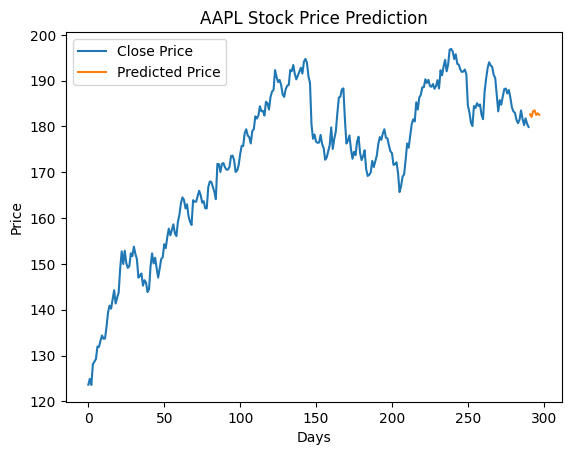

In [12]:
#Plot predictions with previous days

plt.plot(np.arange(len(stock_data)), stock_data['Close'], label='Close Price')
plt.plot(np.arange(len(stock_data), len(stock_data) + 7), predictions, label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
